# Starbucks Capstone Challenge
## Project Motivation
**The purpose of this project is to help Starbucks better decisions on sending out offers increase sales and potentially save money. By predicting whether a customer will respond to an offer, Starbucks can make smarter decisions on whether or not to send an offer.**

By sending offers to the RIGHT customers:
- Starbucks can boost brand recognition, customer loyalty, increase sales activities, promote a new product, etc.

By NOT sending offers to the RIGHT customers:
- Starbucks can save costs on the promotion event on customers **who would make purchases without offers**
- Starbucks can prevent customers to react negatively to an offer by not sending the offer

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, r2_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-whitegrid')

In [2]:
# read in the cleaned datasets
offers = pd.read_csv('cleaned_data/offers.csv')
customers = pd.read_csv('cleaned_data/customers.csv')
events = pd.read_csv('cleaned_data/events.csv')
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 16994 rows
events has 306514 rows


# Create customer_funnels dataset to analyze offer response

In [3]:
# Add offer info into events dataset
events = pd.merge(events, offers[['id','offer']], how='left', left_on='offer_id', right_on='id').drop(['id','offer_id'],axis=1)
events.offer.unique()

array(['bogo_5_7_5', 'discount_20_10_5', 'discount_10_7_2',
       'discount_10_10_2', 'bogo_10_5_10', 'bogo_5_5_5', 'discount_7_7_3',
       'informational_0_4_0', 'bogo_10_7_10', 'informational_0_3_0', nan],
      dtype=object)

In [4]:
# Store offer types
informational_offers = ['informational_0_3_0','informational_0_4_0']
discount_offers = ['discount_20_10_5','discount_10_7_2','discount_10_10_2','discount_7_7_3']
bogo_offers = ['bogo_5_7_5','bogo_10_5_10','bogo_5_5_5','bogo_10_7_10']

# Remove informational events out of events data
informational_events = events[events.offer.isin(informational_offers)]
offer_events = events[~events.offer.isin(informational_offers)]

# Remove transaction events out of events data and store in offer_events
offer_events = offer_events[offer_events.event != 'transaction']
transaction_events = events[events.event == 'transaction']

In [5]:
# Create customer_funnels dataset
customer_funnels = offer_events.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
customer_funnels = pd.pivot(customer_funnels, index='customer_id', columns='event', values='count')
customer_funnels.columns = [col.replace(' ', '_') for col in customer_funnels.columns]
customer_funnels.sample(5)

,offer_completed,offer_received,offer_viewed
customer_id,,,
ff7fdf82996949ec82d158a02a1d9cca,4.0,4.0,4.0
5e1d43101c2640b0af02f9c0f6a32755,NaN,2.0,2.0
774d4dd8316449afb52b3121f296aec6,3.0,3.0,2.0
20bdd36e61ab4b13ad5fbecb2c5653bb,3.0,4.0,4.0
4be1127413db496d8103c783ae72058b,1.0,3.0,2.0


- 100% customers in this data received at least 1 offer
- 24.5% customers didn't complete the offer
- 2.4% customers didn't view the offer

In [6]:
customer_funnels.isnull().mean() * 100

offer_completed    24.539225
offer_received      0.000000
offer_viewed        2.392486
dtype: float64

## Define Customer Response
**A user can receive an offer, never actually view the offer, and still complete the offer.**  
**As a result, we want to segment all customers into 3 groups:**
- **responded**
    - customers who were influenced by the offer and made a purchase - those who **RECEIVED, VIEWED, AND COMPLETED THE OFFER**
- **not_responded**
    - customers who were not influenced by the offer and didn't make a purchase - those who **RECEIVED, VIEWED, AND NOT COMPLETED THE OFFER**
- **invalid_responded**
    - customers who were not influenced by the offer but did make a purchase - those who **RECEIVED, NOT VIEWED, BUT COMPLETED THE OFFER**

In [7]:
def create_3_demo_groups(funnel):

    responded = funnel.dropna()
    not_responded = funnel[funnel.offer_completed.isnull()]
    invalid_responded = funnel[funnel.offer_completed.notnull() & funnel.offer_viewed.isnull()]

    print(round(len(responded)/len(funnel)*100,2), '% customers responded to offers')
    print(round(len(not_responded)/len(funnel)*100,2), '% customers did not respond to any offer')
    print(round(len(invalid_responded)/len(funnel)*100,2), '% customers completed offers without viewing offer')

    # Make sure these 3 demographic groups are broken down correctly
    assert len(responded) + len(not_responded) + len(invalid_responded) == len(funnel), '3 demographic groups not broken down correctly'  

    return responded, not_responded, invalid_responded

### customer_funnels represents customer responses for all offers
So we know that for all offers:
- 74.4 % customers responded to offers
- 24.54 % customers did not respond to any offer
- 1.06 % customers completed offers without viewing offer

**Later on, the funnel input for the above function can be funnels for a specific offer, to analyze each offer individually**

In [8]:
responded, not_responded, invalid_responded = create_3_demo_groups(customer_funnels)

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


### Analyze demographics for the 3 response groups
- If we look at the "not responded" group (orange distribution), we can conclude that customers with young age, low income, and a short period of membership are likely to not respond to offers
- The green and blue distributions are relatively similar, while the green distribution (completed the offer without viewing) is slightly skewed to higher age, higher income, and longer membership period

In [9]:
null_customers = customers[customers.isnull().any(axis=1)]
customers = customers.dropna()

In [10]:
def plot_compare_3_groups(funnel):

    responded, not_responded, invalid_responded = create_3_demo_groups(funnel)

    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    sns.distplot(customers[customers.id.isin(responded.index)].age, label='responded');
    sns.distplot(customers[customers.id.isin(not_responded.index)].age, label='not responded');
    sns.distplot(customers[customers.id.isin(invalid_responded.index)].age, label='invalid responded');
    plt.legend();

    plt.subplot(1,3,2)
    sns.distplot(customers[customers.id.isin(responded.index)].income, label='responded');
    sns.distplot(customers[customers.id.isin(not_responded.index)].income, label='not responded');
    sns.distplot(customers[customers.id.isin(invalid_responded.index)].income, label='invalid responded');
    plt.legend();

    plt.subplot(1,3,3)
    sns.distplot(customers[customers.id.isin(responded.index)].membership_days, label='responded');
    sns.distplot(customers[customers.id.isin(not_responded.index)].membership_days, label='not responded');
    sns.distplot(customers[customers.id.isin(invalid_responded.index)].membership_days, label='invalid responded');
    plt.legend();

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


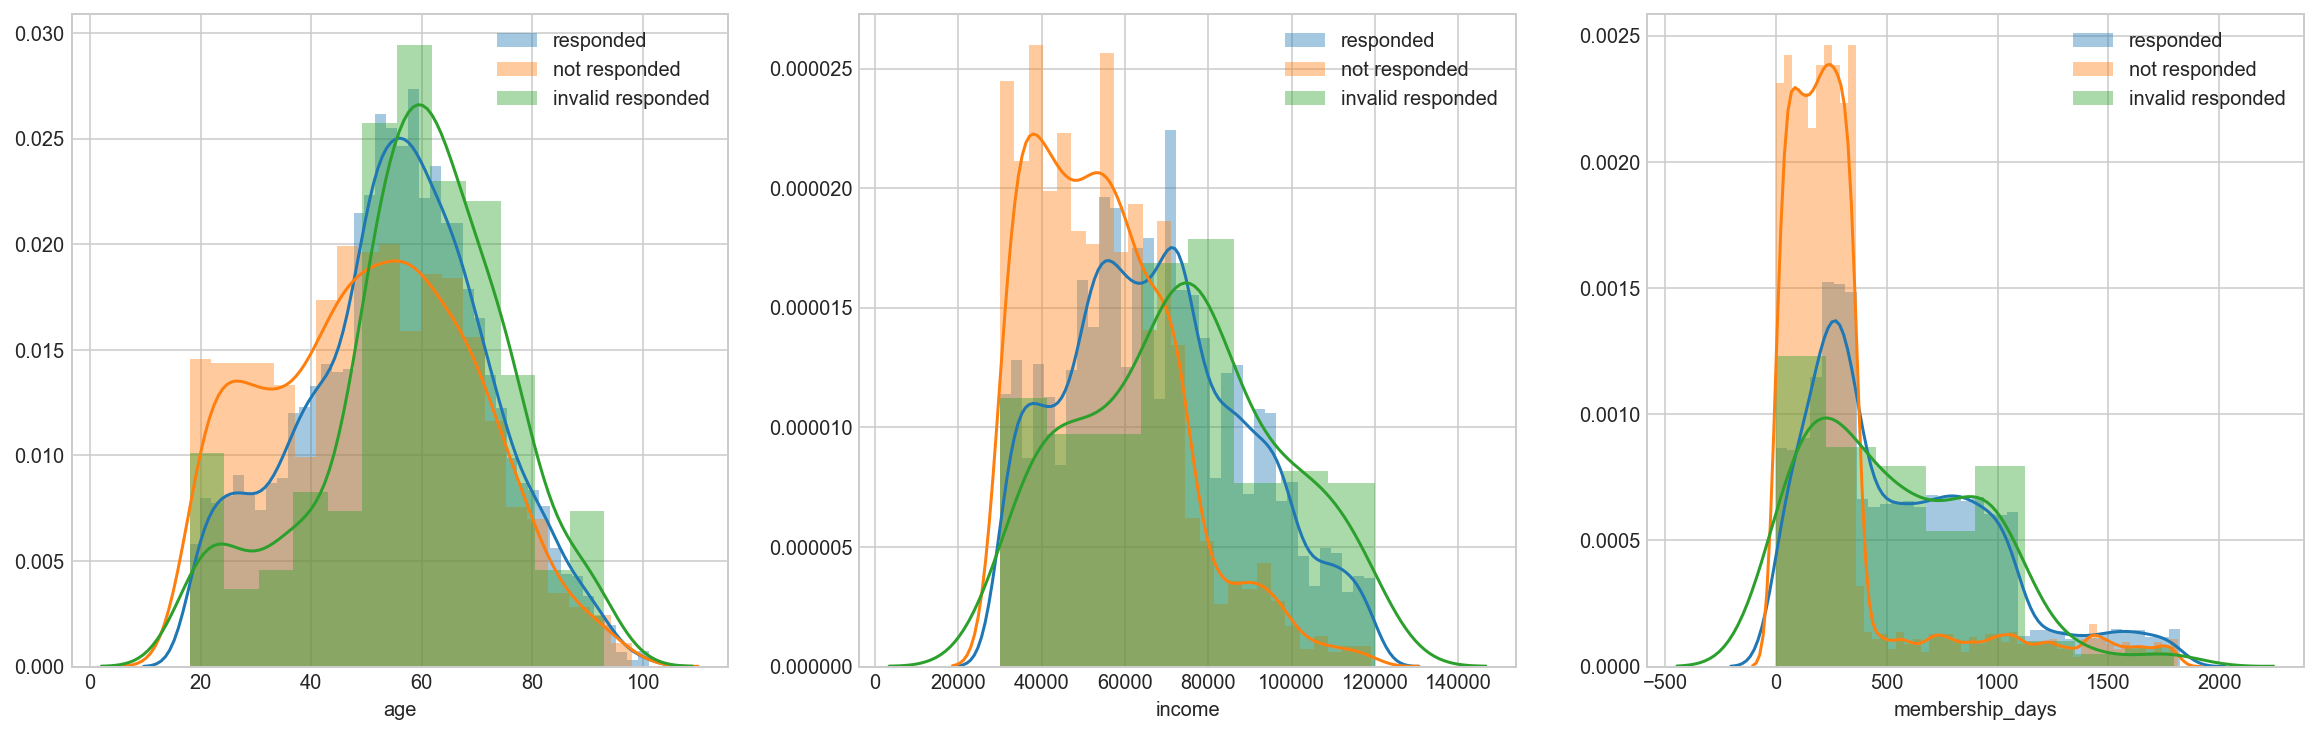

In [11]:
plot_compare_3_groups(customer_funnels)

# Dig deeper into customers funnels by seperating offers

In [12]:
def create_offer_funnels(offer):

    funnel = offer_events[offer_events.offer == offer]
    funnel = funnel.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
    funnel = pd.pivot(funnel, index='customer_id', columns='event', values='count')
    funnel.columns = [col.replace(' ', '_') for col in funnel.columns]
    funnel['completion_rate'] = funnel.offer_completed / funnel.offer_received

    return funnel

In [13]:
create_offer_funnels('discount_7_7_3').sample(5)

,offer_completed,offer_received,offer_viewed,completion_rate
customer_id,,,,
4d70dd97b0004d47ad520d33da69b6da,NaN,1.0,1.0,NaN
7685603a1b034f12b5b682f483c316d6,1.0,2.0,2.0,0.5
982afcfac1bf4f2183a1d6ce7cd44e29,NaN,1.0,1.0,NaN
95d0334b42b64eda80ecb98f3dc7fc77,NaN,1.0,1.0,NaN
3c8b13e129d44befaf5ca29994a484c5,2.0,2.0,2.0,1.0


# Analyze customer response for the 4 discount offers

In [14]:
discount_offers

['discount_20_10_5', 'discount_10_7_2', 'discount_10_10_2', 'discount_7_7_3']

23.09 % customers responded to offers
53.28 % customers did not respond to any offer
23.63 % customers completed offers without viewing offer


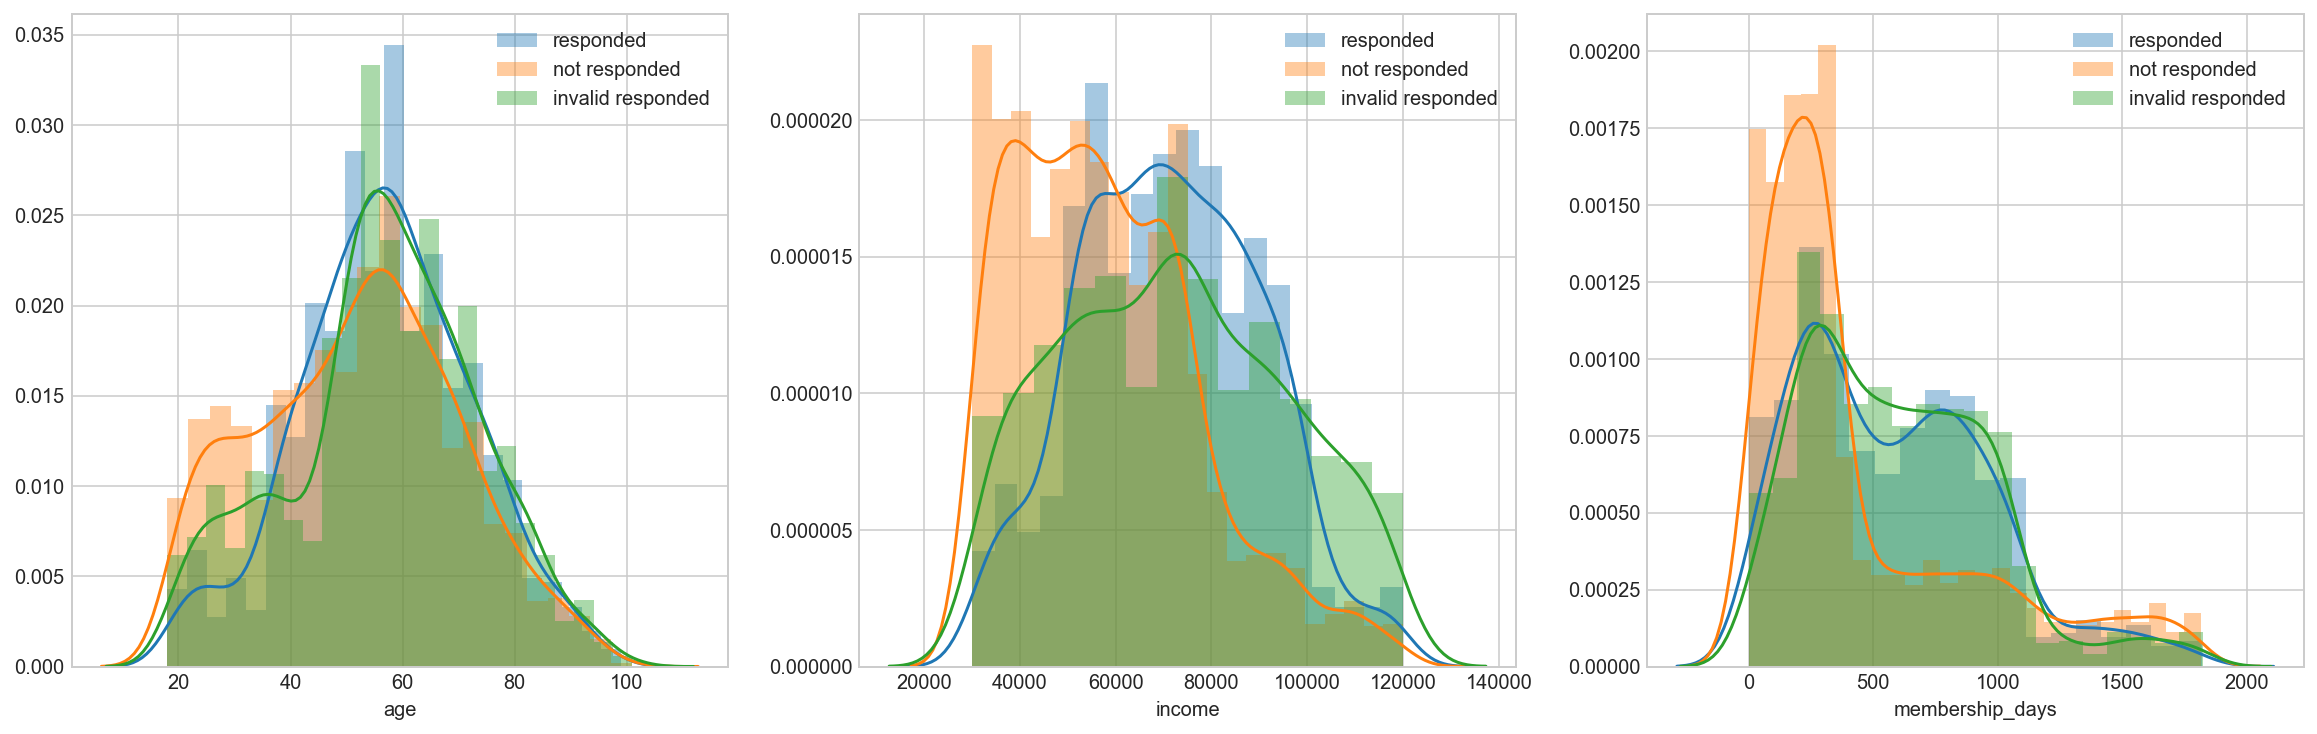

In [19]:
plot_compare_3_groups(create_offer_funnels('discount_20_10_5'))

38.42 % customers responded to offers
44.63 % customers did not respond to any offer
16.95 % customers completed offers without viewing offer


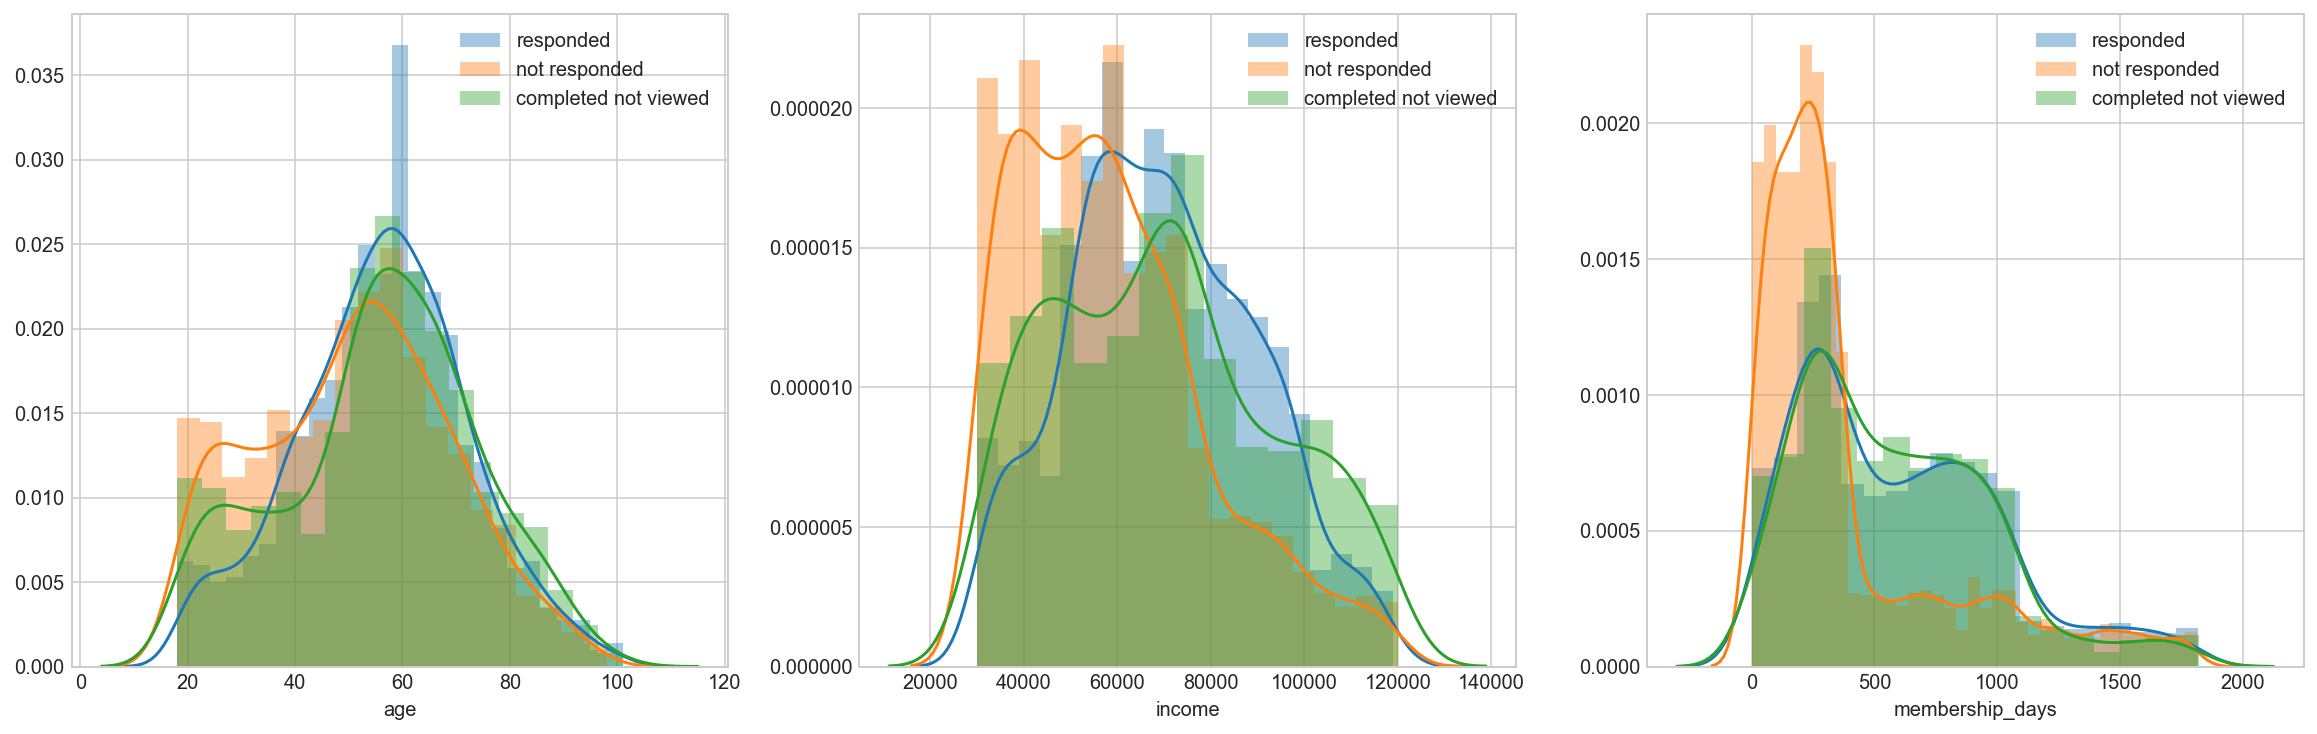

In [21]:
plot_compare_3_groups(create_offer_funnels('discount_10_7_2'))

70.01 % customers responded to offers
28.46 % customers did not respond to any offer
1.53 % customers completed offers without viewing offer


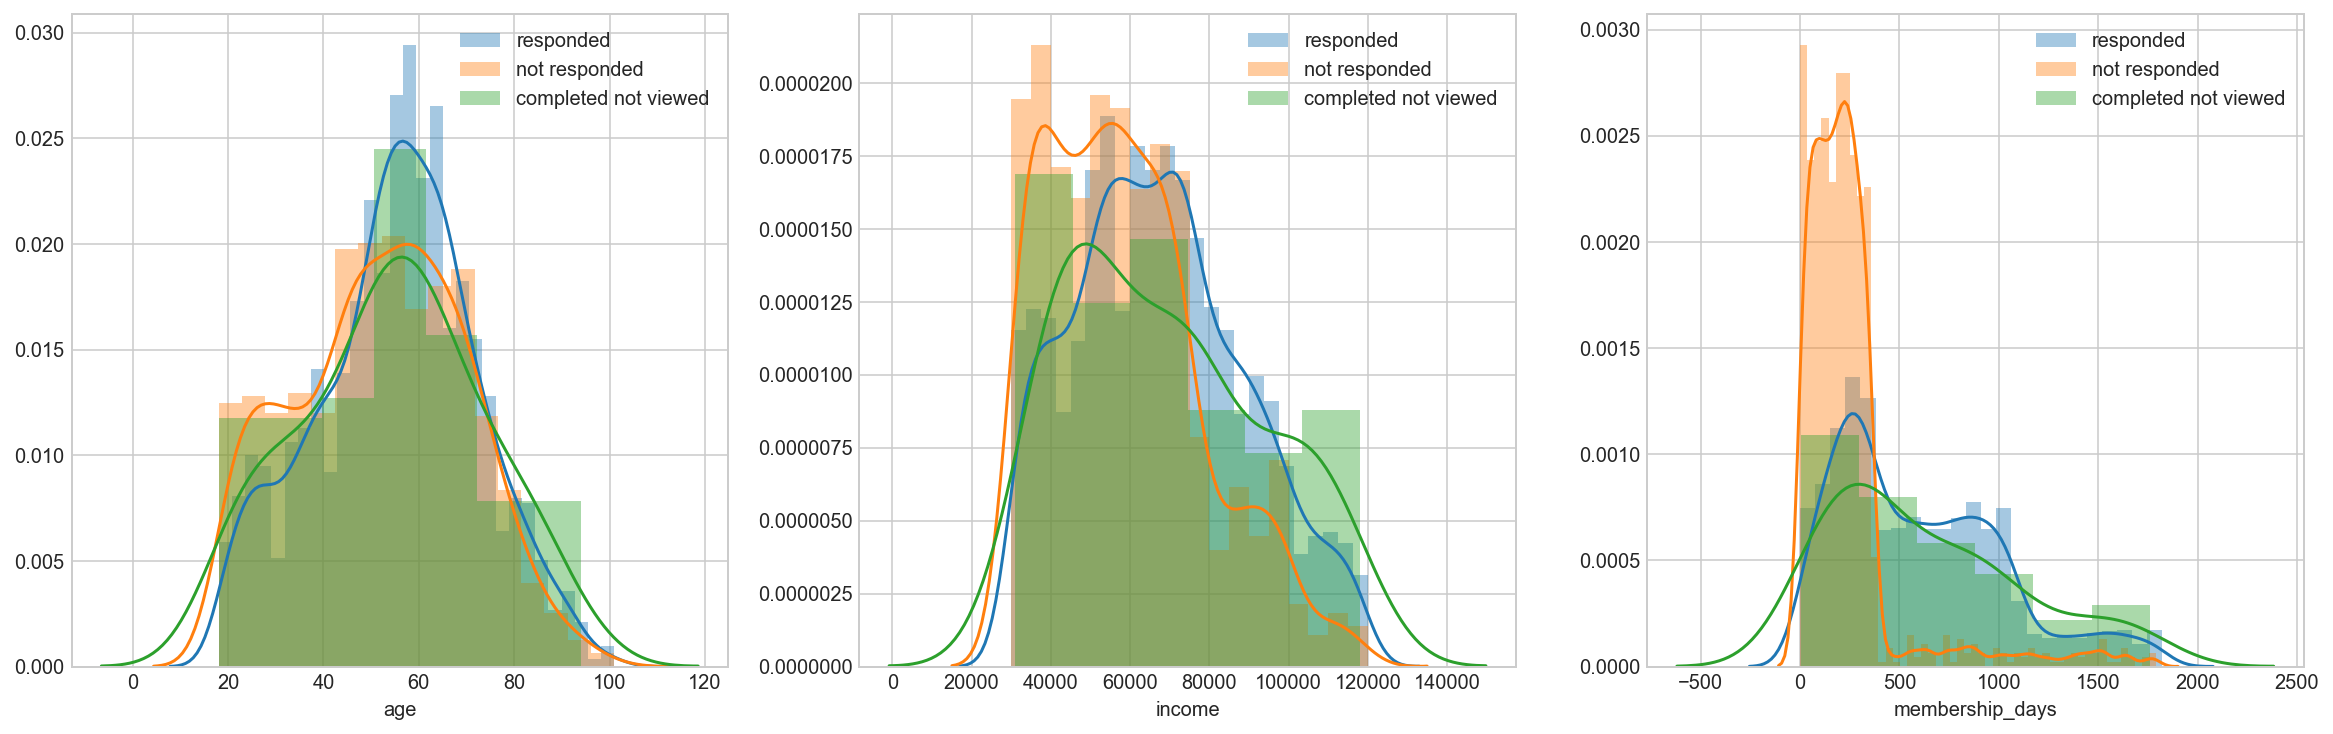

In [26]:
plot_compare_3_groups(create_offer_funnels('discount_10_10_2'))

68.19 % customers responded to offers
30.1 % customers did not respond to any offer
1.71 % customers completed offers without viewing offer


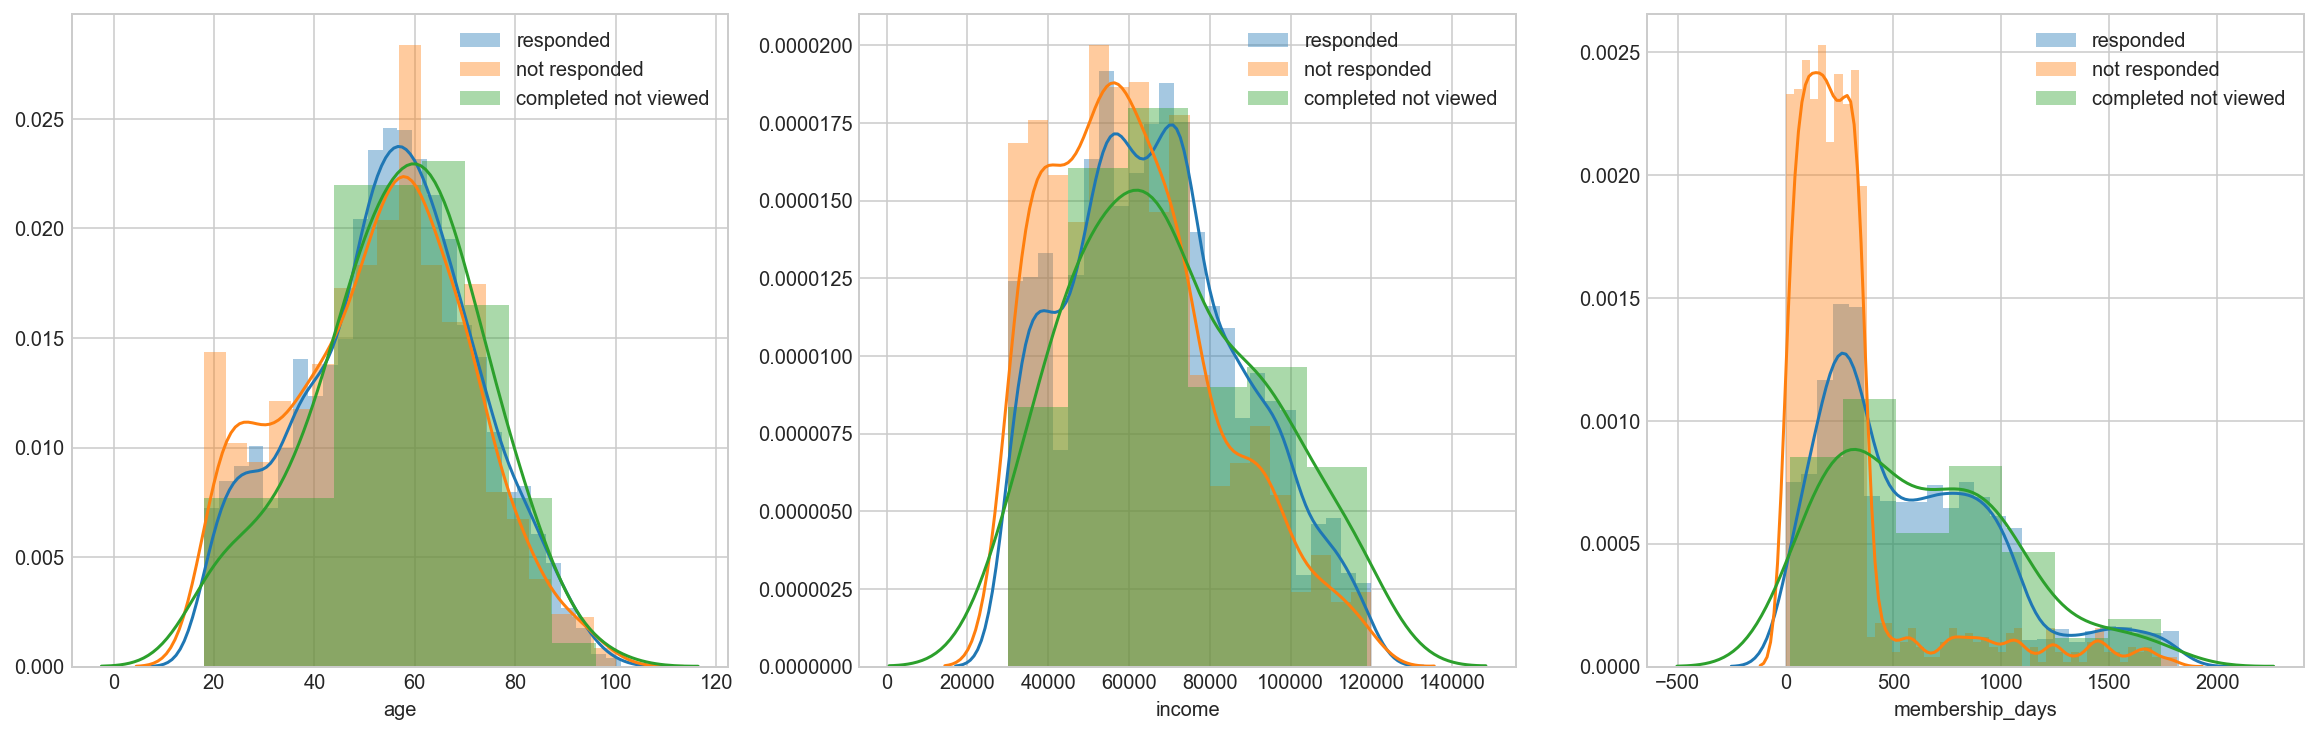

In [21]:
plot_compare_3_groups(create_offer_funnels('discount_7_7_3'))

# Analyze customer response for the 4 BOGO offers

In [15]:
bogo_offers

['bogo_5_7_5', 'bogo_10_5_10', 'bogo_5_5_5', 'bogo_10_7_10']

39.4 % customers responded to offers
40.46 % customers did not respond to any offer
20.14 % customers completed offers without viewing offer


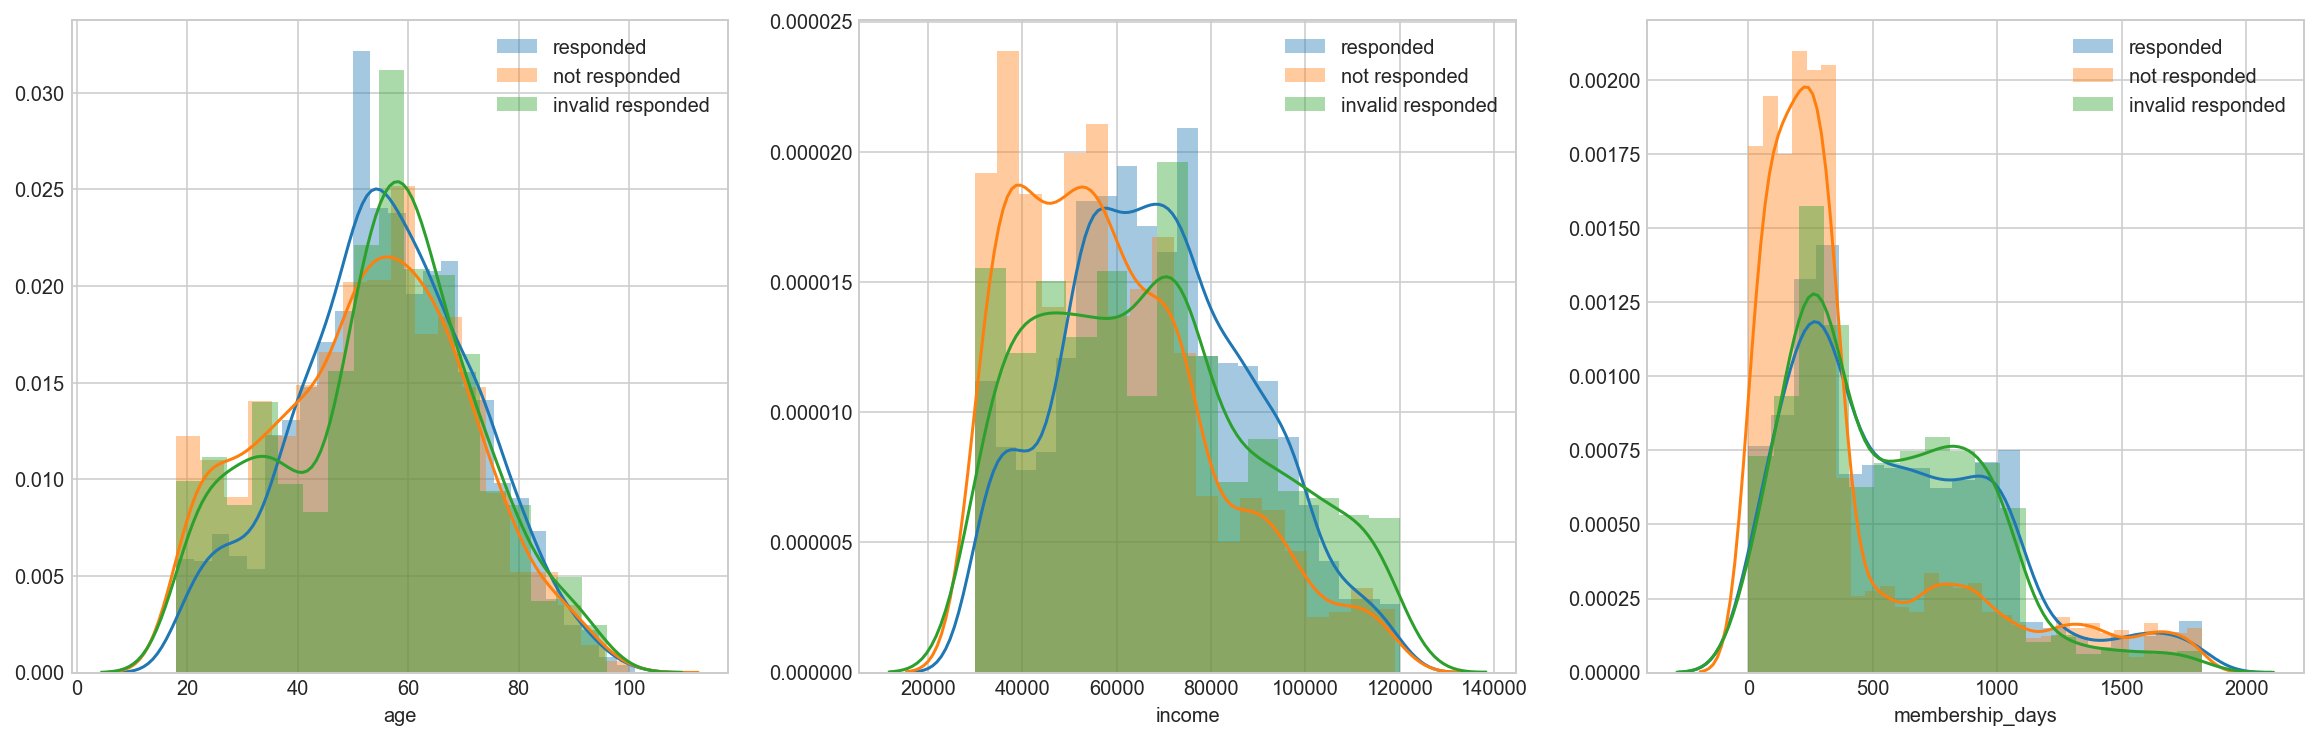

In [16]:
plot_compare_3_groups(create_offer_funnels('bogo_5_7_5'))

44.63 % customers responded to offers
54.42 % customers did not respond to any offer
0.95 % customers completed offers without viewing offer


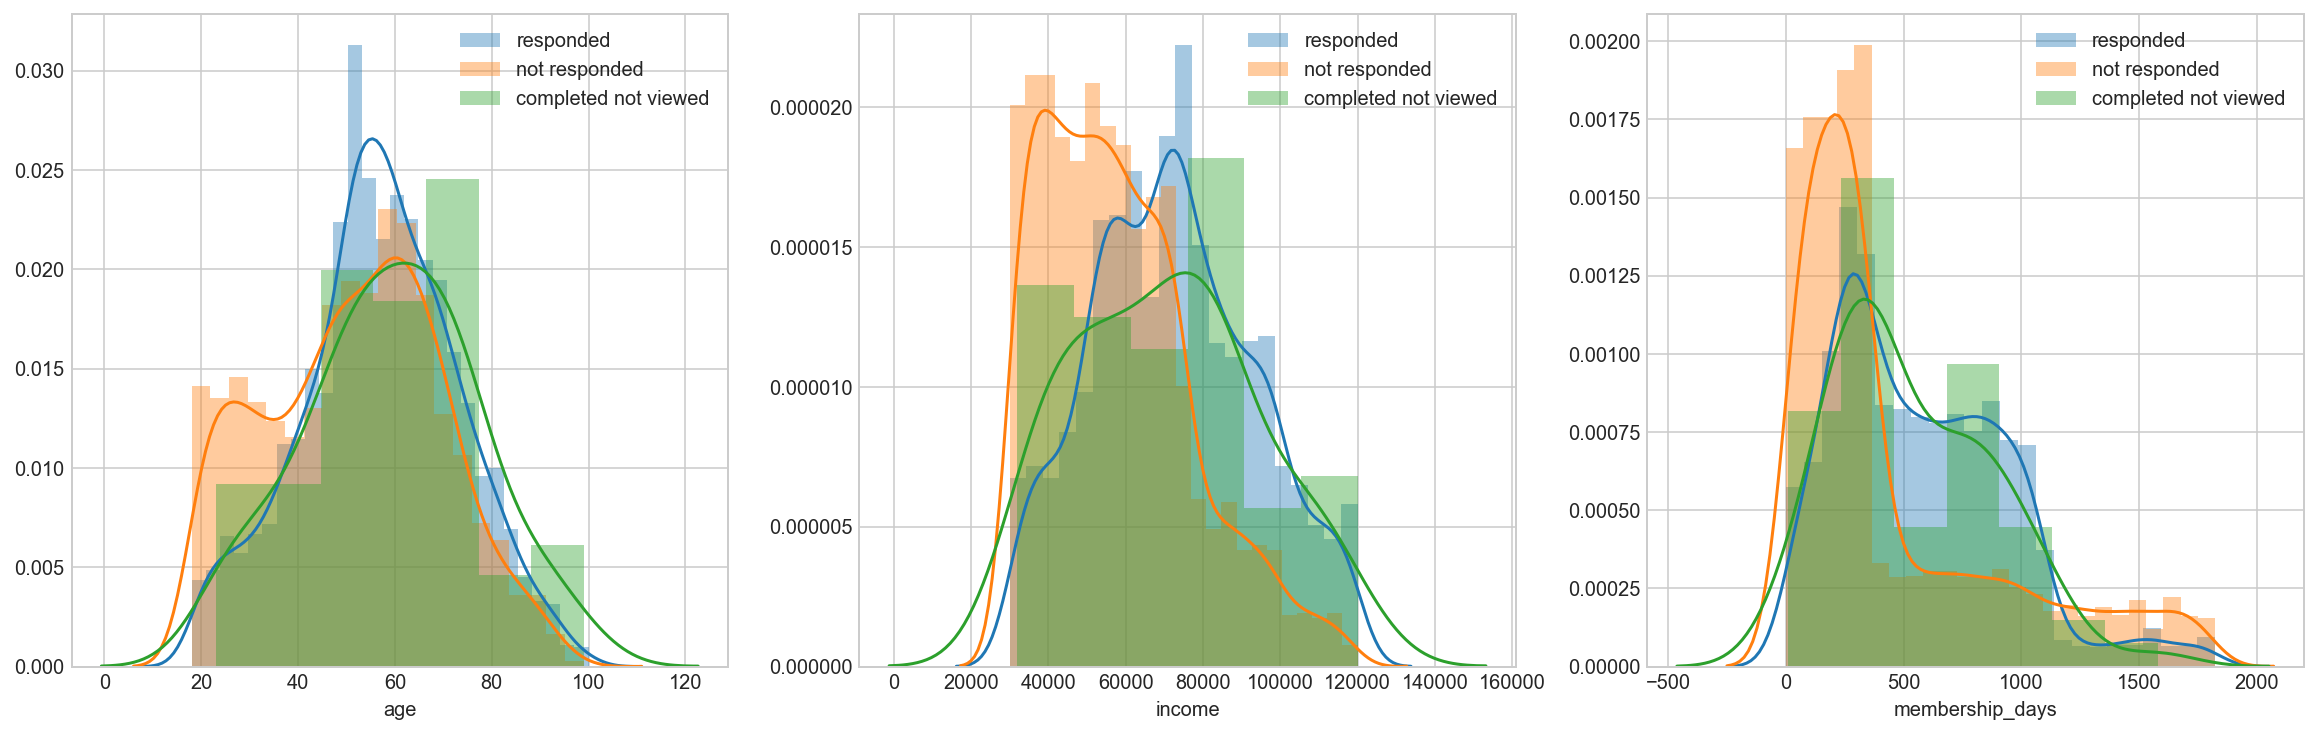

In [29]:
plot_compare_3_groups(create_offer_funnels('bogo_10_5_10'))

58.37 % customers responded to offers
40.26 % customers did not respond to any offer
1.37 % customers completed offers without viewing offer


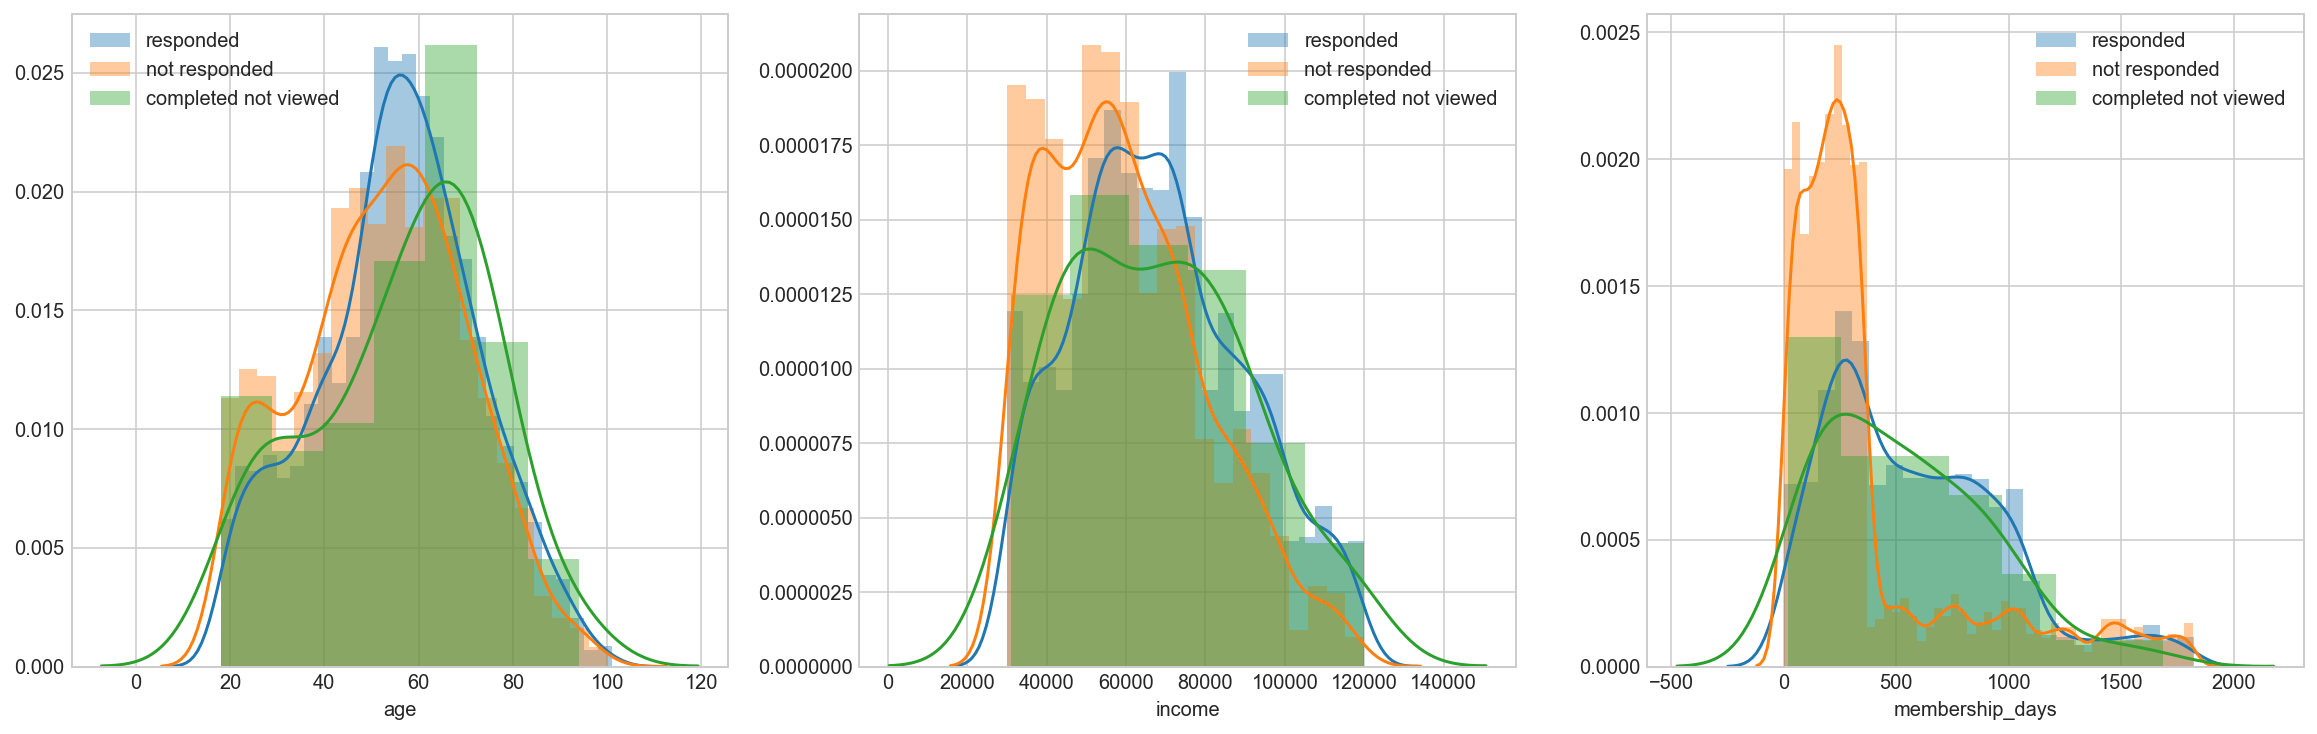

In [30]:
plot_compare_3_groups(create_offer_funnels('bogo_5_5_5'))

44.6 % customers responded to offers
50.16 % customers did not respond to any offer
5.24 % customers completed offers without viewing offer


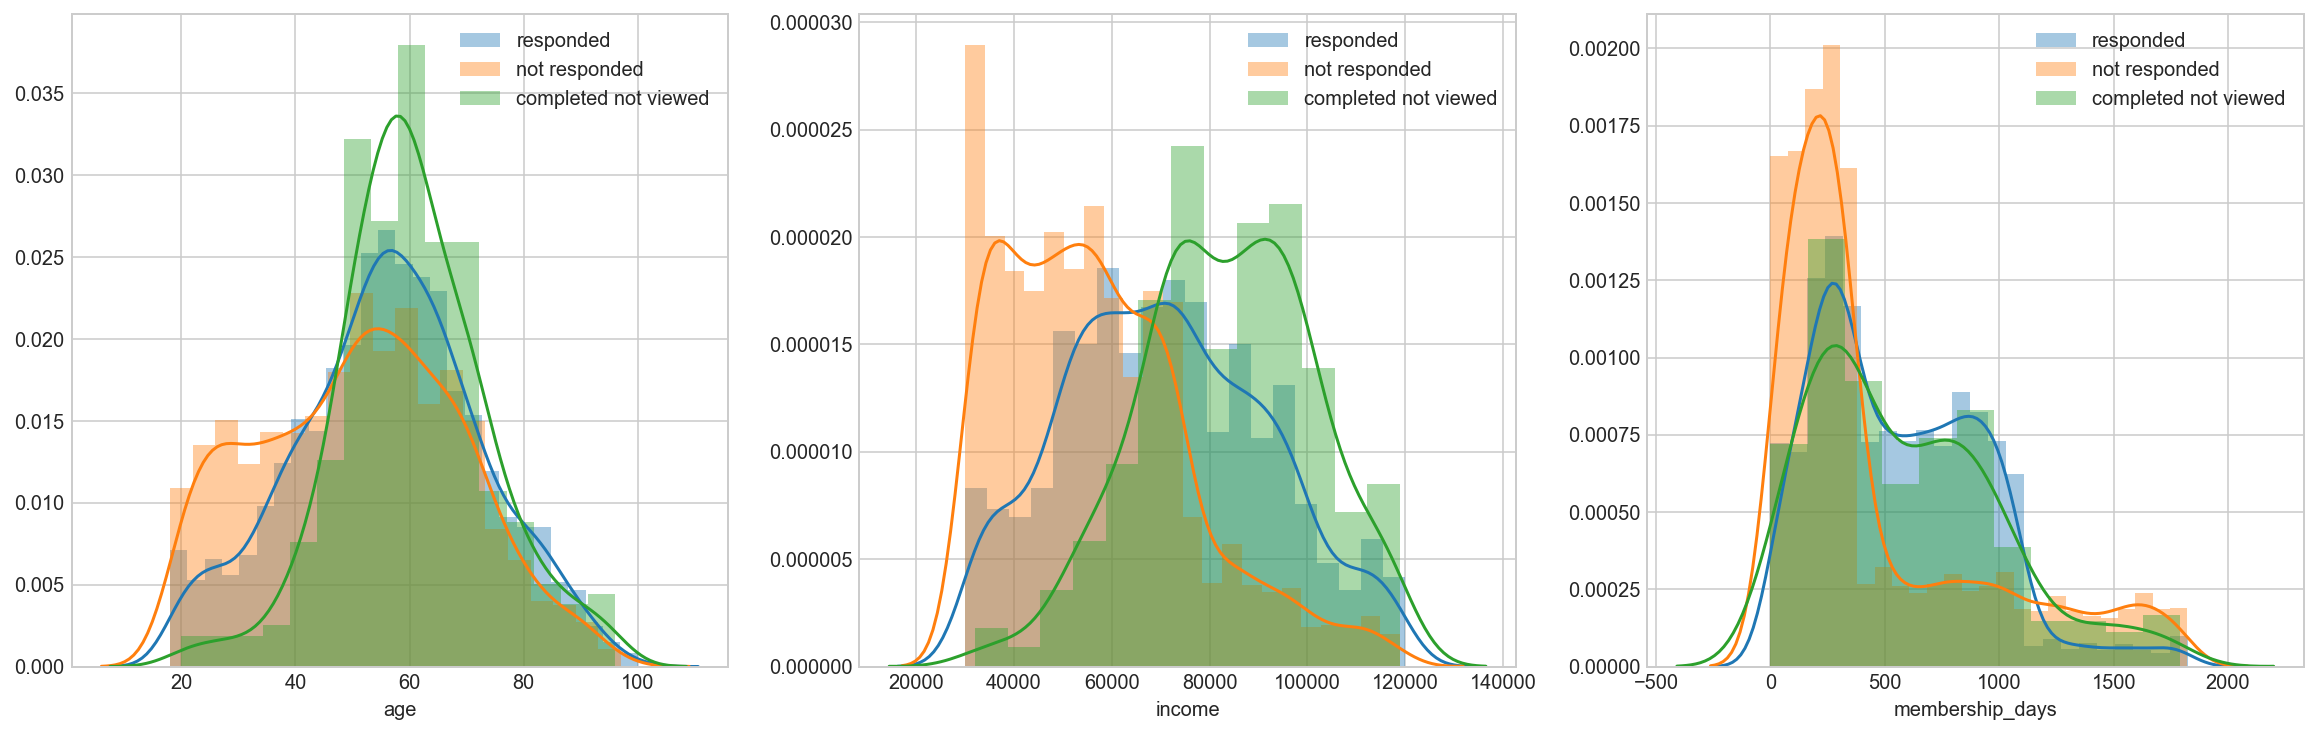

In [31]:
plot_compare_3_groups(create_offer_funnels('bogo_10_7_10'))

### Implementation
While we have a function to extract customer ids based on offer_type and offer_id, we can create new features in the customers data - whether the customer responded to offer A, offer B, ... discount offers, BOGO offers, etc.

In [17]:
responded, not_responded, invalid_responded = create_3_demo_groups(customer_funnels)

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


In [18]:
customers['response'] = customers.id.isin(responded.index).astype(int)
customers['invalid_response'] = customers.id.isin(invalid_responded.index).astype(int)
customers.head()

,gender,age,id,income,membership_days,response,invalid_response
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0


In [19]:
def get_responded_ids(offer):

    funnel = create_offer_funnels(offer)
    responded = funnel.dropna().index

    return responded

In [20]:
for offer in bogo_offers:
    customers[offer] = customers.id.isin(get_responded_ids(offer)).astype(int)
for offer in discount_offers:
    customers[offer] = customers.id.isin(get_responded_ids(offer)).astype(int)

customers.head()

,gender,age,id,income,membership_days,response,invalid_response,bogo_5_7_5,bogo_10_5_10,bogo_5_5_5,bogo_10_7_10,discount_20_10_5,discount_10_7_2,discount_10_10_2,discount_7_7_3
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1,0,0,0,0,0,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,1,0,1,1,0,0,0,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,1,0,0,0,0,0,1,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,1,0,1,0,0,1,1,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,0,0,0,0,0,1,0


In [21]:
def invalid_responded_ids(offer):

    funnel = create_offer_funnels(offer)
    invalid_responded = funnel[funnel.offer_completed.notnull() & funnel.offer_viewed.isnull()].index

    return invalid_responded

In [22]:
for offer in bogo_offers:
    customers['invalid_'+offer] = customers.id.isin(invalid_responded_ids(offer)).astype(int)
for offer in discount_offers:
    customers['invalid_'+offer] = customers.id.isin(invalid_responded_ids(offer)).astype(int)

customers.head()

,gender,age,id,income,membership_days,response,invalid_response,bogo_5_7_5,bogo_10_5_10,bogo_5_5_5,...,discount_10_10_2,discount_7_7_3,invalid_bogo_5_7_5,invalid_bogo_10_5_10,invalid_bogo_5_5_5,invalid_bogo_10_7_10,invalid_discount_20_10_5,invalid_discount_10_7_2,invalid_discount_10_10_2,invalid_discount_7_7_3
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [23]:
transaction_events.head()

,customer_id,event,hour,amount_spent,reward_received,offer
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,NaN,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,NaN,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51,NaN,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97,NaN,NaN


In [24]:
transaction_events['week'] = (transaction_events.hour / 24 / 7).astype(int)
transactions = transaction_events.groupby(['customer_id','week']).event.count().to_frame().reset_index()
transactions.rename({'event':'avg_weekly_transactions'},axis=1,inplace=True)
transactions = transactions.groupby('customer_id').avg_weekly_transactions.mean().to_frame().reset_index()
transactions.head()

,customer_id,avg_weekly_transactions
0,0009655768c64bdeb2e877511632db8f,2.000000
1,00116118485d4dfda04fdbaba9a87b5c,1.500000
2,0011e0d4e6b944f998e987f904e8c1e5,1.666667
3,0020c2b971eb4e9188eac86d93036a77,2.666667
4,0020ccbbb6d84e358d3414a3ff76cffd,2.400000


In [25]:
customers = pd.merge(customers, transactions, how='left', left_on='id', right_on='customer_id')
customers.drop('customer_id',axis=1,inplace=True)
customers.head()

,gender,age,id,income,membership_days,response,invalid_response,bogo_5_7_5,bogo_10_5_10,bogo_5_5_5,...,discount_7_7_3,invalid_bogo_5_7_5,invalid_bogo_10_5_10,invalid_bogo_5_5_5,invalid_bogo_10_7_10,invalid_discount_20_10_5,invalid_discount_10_7_2,invalid_discount_10_10_2,invalid_discount_7_7_3,avg_weekly_transactions
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1.500000
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1.750000
2,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.500000
3,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1.000000
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.333333


In [26]:
amount_spent = transaction_events.groupby(['customer_id','week']).amount_spent.mean().to_frame().reset_index()
amount_spent = amount_spent.groupby('customer_id').amount_spent.mean().to_frame().reset_index()
amount_spent.rename({'amount_spent':'avg_weekly_amount_spent'},axis=1,inplace=True)
amount_spent.head()

,customer_id,avg_weekly_amount_spent
0,0009655768c64bdeb2e877511632db8f,16.647500
1,00116118485d4dfda04fdbaba9a87b5c,1.197500
2,0011e0d4e6b944f998e987f904e8c1e5,14.477778
3,0020c2b971eb4e9188eac86d93036a77,24.615833
4,0020ccbbb6d84e358d3414a3ff76cffd,12.077500


In [27]:
customers = pd.merge(customers, amount_spent, how='left',left_on='id',right_on='customer_id')
customers.drop('customer_id',axis=1,inplace=True)
customers.head()

,gender,age,id,income,membership_days,response,invalid_response,bogo_5_7_5,bogo_10_5_10,bogo_5_5_5,...,invalid_bogo_5_7_5,invalid_bogo_10_5_10,invalid_bogo_5_5_5,invalid_bogo_10_7_10,invalid_discount_20_10_5,invalid_discount_10_7_2,invalid_discount_10_10_2,invalid_discount_7_7_3,avg_weekly_transactions,avg_weekly_amount_spent
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1.500000,25.057500
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1.750000,22.900000
2,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1.500000,19.037500
3,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1.000000,12.143333
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.333333,3.135000


In [29]:
customers.fillna(0,inplace=True)

In [34]:
# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# sns.distplot(customers.avg_weekly_amount_spent);
# plt.subplot(1,2,2)
# sns.distplot(customers.avg_weekly_transactions);
# plt.tight_layout()

In [167]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_customers = customers.copy()
scaled_customers.set_index('id',inplace=True)
scaled_customers = pd.get_dummies(scaled_customers)
scaled_customers = scaler.fit_transform(scaled_customers)

In [71]:
# scaled_customers = customers.copy()
# scaled_customers.set_index('id', inplace=True)
# scaled_customers = pd.get_dummies(scaled_customers)
# scaled_customers.head()

,age,income,membership_days,response,invalid_response,bogo_5_7_5,bogo_10_5_10,bogo_5_5_5,bogo_10_7_10,discount_20_10_5,...,invalid_discount_20_10_5,invalid_discount_10_7_2,invalid_discount_10_10_2,invalid_discount_7_7_3,avg_weekly_transactions,avg_weekly_amount_spent,cluster,gender_F,gender_M,gender_O
id,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55.0,112000.0,376,0,1,0,0,0,0,0,...,0,0,0,0,1.500000,25.057500,3,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,443,1,0,1,0,1,1,0,...,0,0,0,0,1.750000,22.900000,1,1,0,0
e2127556f4f64592b11af22de27a7932,68.0,70000.0,91,1,0,1,0,0,0,0,...,0,0,0,0,1.500000,19.037500,2,0,1,0
389bc3fa690240e798340f5a15918d5c,65.0,53000.0,167,1,0,1,0,1,0,0,...,0,0,0,0,1.000000,12.143333,2,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,58.0,51000.0,257,1,0,0,0,0,0,0,...,0,0,0,0,1.333333,3.135000,2,0,1,0


In [182]:
# Cluster the page level data for further insights
kmeans = KMeans(n_clusters=3, random_state=42)
customers['cluster'] = kmeans.fit_predict(scaled_customers)
customers['cluster'] = customers.cluster + 1

In [183]:
customers.cluster.value_counts()

3    6332
1    5494
2    2994
Name: cluster, dtype: int64

In [184]:
def compare_cluster_distributions(feature):
    for cluster in customers.cluster.unique():
        sns.distplot(customers[customers.cluster == cluster][feature], label=cluster)
        plt.legend()

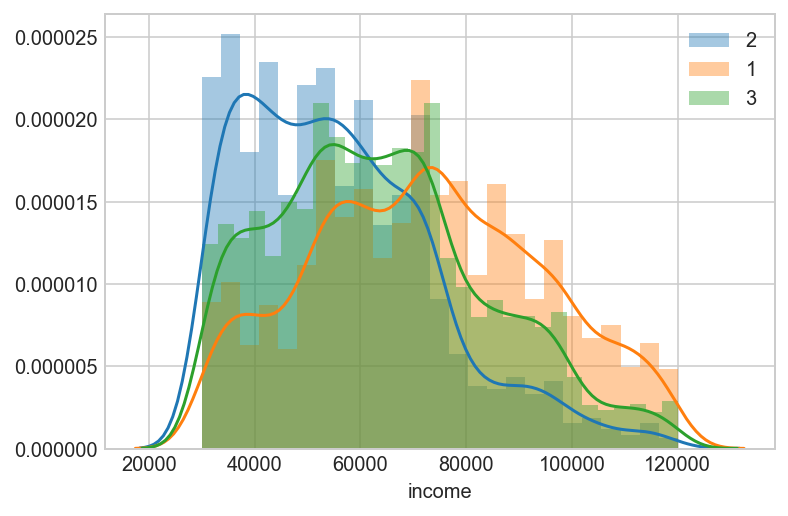

In [185]:
compare_cluster_distributions('income')

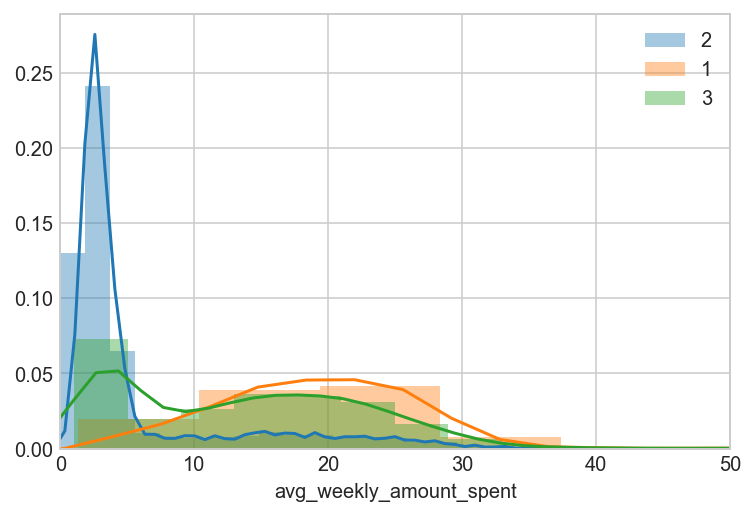

In [186]:
compare_cluster_distributions('avg_weekly_amount_spent')
plt.xlim(0,50);

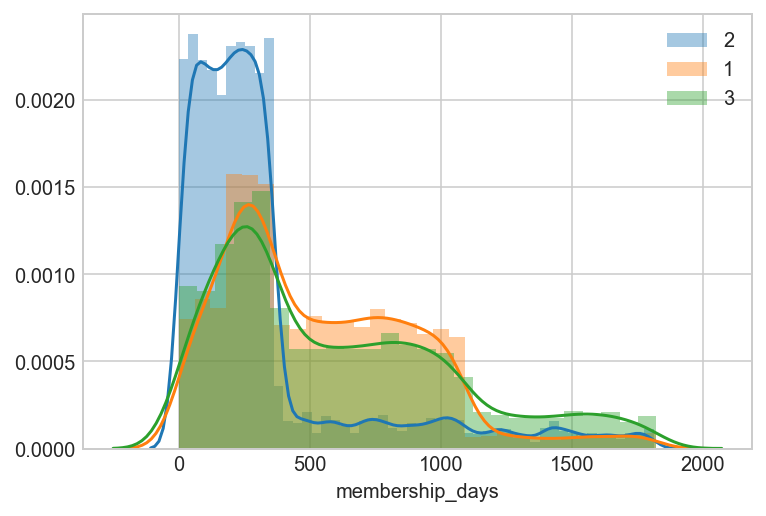

In [188]:
compare_cluster_distributions('membership_days')

In [199]:
def compare_cluster_ratios(list_of_features):

    for i, feature in enumerate(list_of_features):
        plt.subplot(2,2,i+1)
        ratios = customers.groupby('cluster')[feature].mean().to_frame()
        sns.barplot(ratios.index, ratios[feature])
        plt.ylabel('')
        plt.title(feature)
        plt.tight_layout()

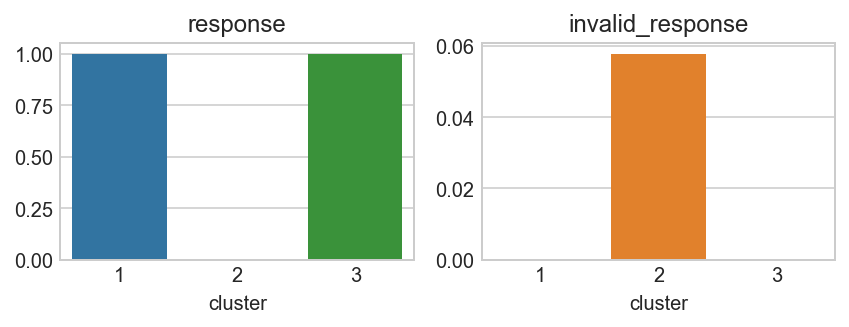

In [200]:
compare_cluster_ratios(['response','invalid_response'])

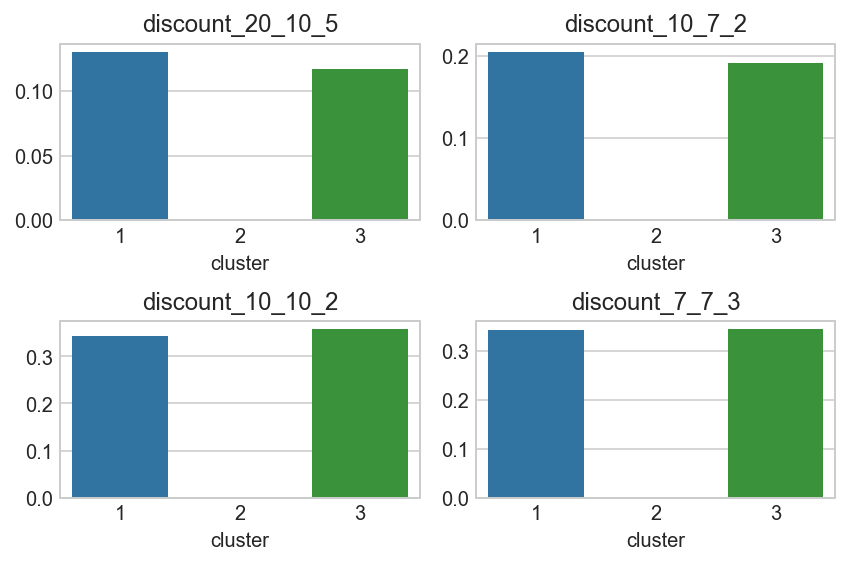

In [201]:
compare_cluster_ratios(discount_offers)

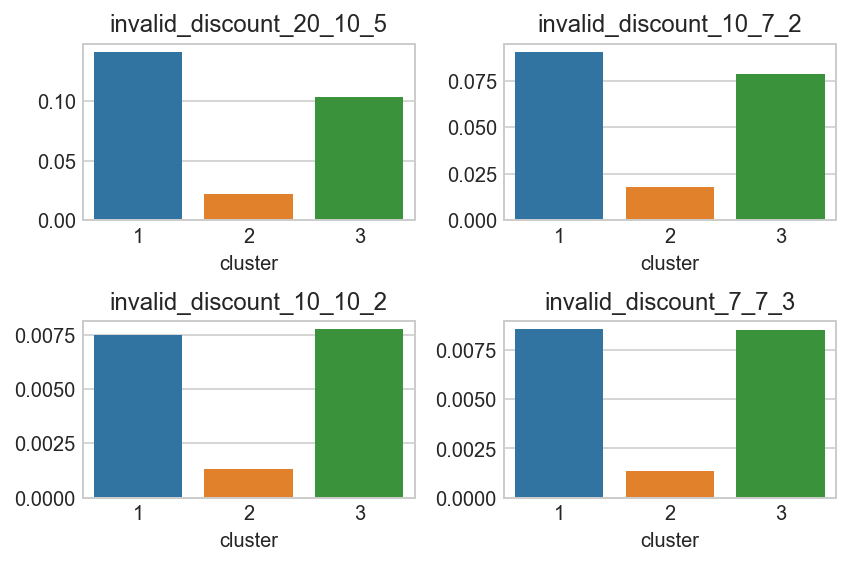

In [204]:
compare_cluster_ratios(['invalid_'+i for i in discount_offers])

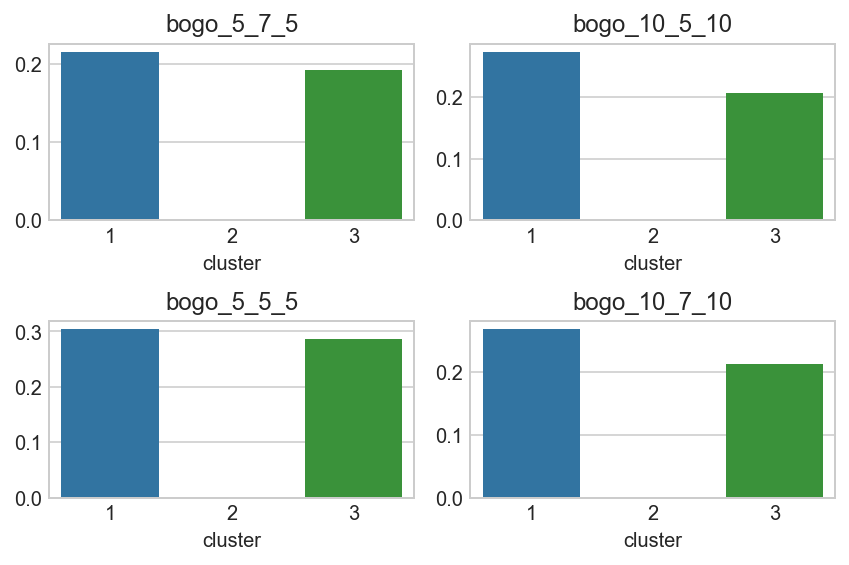

In [202]:
compare_cluster_ratios(bogo_offers)

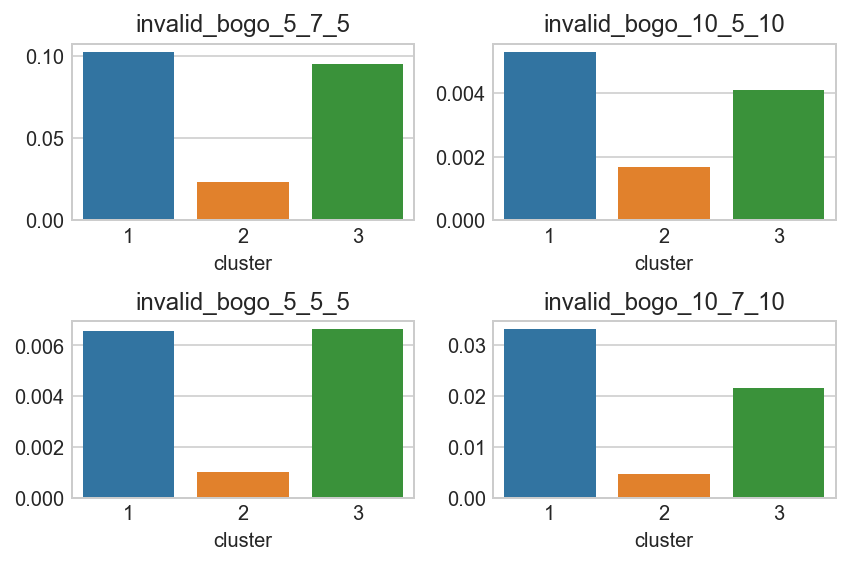

In [203]:
compare_cluster_ratios(['invalid_'+i for i in bogo_offers])

### The reason why this ratio is different is because customer_funnels has removed some customers with only informational offer events

In [26]:
# Examine the ratios of target classes to decide on the classification metrics
# Accuracy seems like a good metric for balanced classes
print('response ratios:')
print(customers.response.value_counts() / len(customers))

response ratios:
1    0.797031
0    0.202969
Name: response, dtype: float64


 # Build Models to classify customer response to offers
- By predicting whether a customer will respond to a certain type of offer (discount / bogo), we can build focused marketing campaigns to maximize returns

## Notes:
- 55% of customers responded to discount offers while 45% didn't respond
- 51% of customers responded to bogo offers while 48 percent didn't respond
- Although classes are balanced, I would still choose F1 score as the metric
- Because I'd like to make sure all customers who will respond gets the offer, in the expense of those who won't respond getting the offer

In [25]:
customers.head()

,gender,age,id,income,membership_days,response,completion_rate
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0,1.000000
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,1,1.000000
2,M,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,1,0.666667
3,M,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,1,0.833333
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,1,0.500000


In [26]:
# Split customers data into X and y
X = customers[['gender','age','income','membership_days']]
y = customers['response']

# Convert categorical features into dummy variables
X = pd.get_dummies(X)

## Compare ROC AUC for both target variables (discount, bogo)

In [27]:
def compare_roc():

    # Set discount_response as the target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train three models
    log_reg = LogisticRegression().fit(X_train, y_train)
    rfc = RandomForestClassifier().fit(X_train, y_train)
    adaboost = AdaBoostClassifier().fit(X_train, y_train)

    # Plot ROC comparisons
    temp = plot_roc_curve(rfc, X_test, y_test)
    plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_)
    plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
    plt.title('ROC comparison')

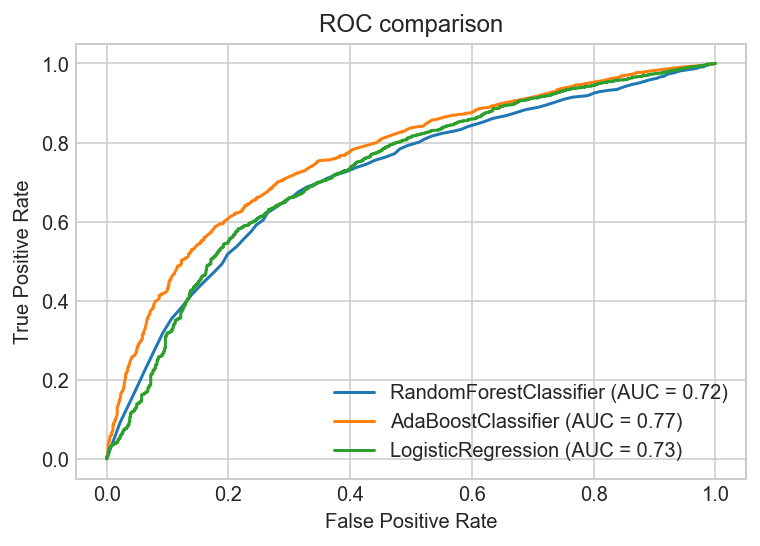

In [28]:
compare_roc()

# Use GridSearchCV to find the best parameters for AdaBoost

In [144]:
# Get available parameters
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

model = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1', return_train_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'best parameters: {model.best_params_}')
print(f'f1 score on the testset: {f1_score(y_test, y_pred)}')
print(f'accuracy on the testset: {accuracy_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 10}
f1 score on the testset: 0.8941041785918717
accuracy on the testset: 0.812753036437247


### Find the optimal probability threshold for the highest F1 scores
- In practice, we can lower the threshold because there is little harm to send offers to those who won't respond

In [150]:
# def find_best_threshold(model, plot=False):

#     # create a hash table of thresholds vs f1 scores
#     res = dict()
#     y_proba_pred = model.predict_proba(X_test)[:,1]

#     for threshold in np.linspace(0,1):
#         res[threshold] = f1_score(y_test, [1 if p > threshold else 0 for p in y_proba_pred])

#     # Find the optimal probability thresholds for the max f1 score
#     for key,value in res.items():
#         if value == max(res.values()):
#             print(key)

#     if plot == True:
#         # plot probability threshold VS F1 scores
#         plt.plot(list(res.keys()), list(res.values()));
#         plt.title('F1 scores by probability thresholds');

In [151]:
# # The best threshold for predicting bogo response is between 0.28 and 0.34 for this test data
# find_best_threshold(model, plot=True)

In [155]:
y = customers['completion_rate']
y

1        1.000000
3        1.000000
5        0.666667
8        0.833333
12       0.500000
           ...   
16989    0.000000
16990    1.000000
16991    0.000000
16992    1.000000
16993    1.000000
Name: completion_rate, Length: 14820, dtype: float64

In [162]:
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50, 70],
    'learning_rate': [0.1, 0.5, 1, 3],
}

model = GridSearchCV(AdaBoostRegressor(), param_grid=parameters, scoring='r2')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'best parameters: {model.best_params_}')
print(f'R-squared score on the testset: {r2_score(y_test, y_pred)}')
# print(f'accuracy on the testset: {accuracy_score(y_test, y_pred)}')

best parameters: {'learning_rate': 0.1, 'n_estimators': 50}
R-squared score on the testset: 0.24276290499943998
